## TS anomaly  detection control plot

In [2]:
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
import statsmodels as ss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import LabelEncoder 

In [3]:
def control_plot(time_series, threshold):
    '''
    Creates a one-sided control plot from a time series
    (that is, plots threshold above the mean but not below)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: z-score threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    
    # Create dataframe of anomalies that exceed the cutoff
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

In [4]:
def cusum(data, mean, shift, threshold):
    '''
    Calculate the high and low cumulative sums and use these for anomaly detection. 
    An anomaly is reported if the cumulative sums are beyong a given threshold.
    
    Args: 
        data: (a time series as pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        mean:  mean of the data or other average (float)
        shift: normal shift in the data; standard deviation is recommend (float)
        threshold: threshold to classify point as anomaly (float)

    Returns: 
        cusum: the high and low cumulative sums together with data (pandas dataframe)  
        anomalies: anomalies that above and below threshold (pandas dataframe)
    ''' 
    high_sum = 0.0
    low_sum = 0.0
    anomalies = [] 
    high_sum_final = []
    low_sum_final = []
    index_names = data.index
    data_values = data.values
    for index, item in enumerate(data_values):
        high_sum = max(0, high_sum + item - mean - shift)
        low_sum = min(0, low_sum + item - mean + shift)
        high_sum_final.append(high_sum)
        low_sum_final.append(low_sum)
        if high_sum > threshold or low_sum < -threshold:
            anomalies.append((index_names[index], item.tolist()))
            
            
    anomalies = pd.DataFrame(res[1], columns=['date', 'value']).explode('value')
    cusum = data
    cusum = cusum.assign(High_Cusum=high_sum_final, Low_Cusum=low_sum_final)
    return cusum, anomalies



def cusum_plot(time_series, threshold):
    '''
    Plot the high and low cumulative sums and use these for anomaly detection. 
    An anomaly is reported if the cumulative sums are beyong a given threshold.
    
    Args: 
        time_series: (a time series as pandas dataframe; index column is date 
        in datetime format and column 0 is data)
        threshold: threshold to classify point as anomaly (float)

    Returns: 
        A plot of the data with the high cumulative sum.
        cusum_results: the high and low cumulative sums together with data 
        and any anomalies that above and below threshold (pandas dataframe; 
        from cumsum function)
    ''' 
    # Use the mean and standard deviation of the whole time series 
    # to calculate cumulative sums
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    plt.figure(figsize=(16,8))
    # define threshold in terms of standard deviation
    cusum_results = cusum(time_series, mean_, stdev_, threshold*stdev_)
    plt.plot(time_series)
    plt.axhline(y=mean_, color='g', linestyle='--',label='average')
    plt.axhline(y=mean_+threshold*stdev_, color='r', linestyle='--',label='High threshold')
#     # Use threshold to plot line at threshold*stdev_ times away from the mean
#     plt.scatter(x=cusum_results[0].index, y=cusum_results[0]['High_Cusum'], 
#               color='k', linestyle=':',label='High Cusum')
    
    plt.scatter(x=cusum_results[1]['date'], y=cusum_results[1]['value'], 
             color='r', marker='*', label='Anomalies', s=100)   
    
    
    plt.legend(loc='upper left')
    plt.title('')
    plt.ylabel('')
    
    plt.grid()
    plt.show()
    
    return cusum_results

In [5]:
data = pd.read_pickle('./data/value_1_data.pckl')
data.head()

id        day  value
0   0 2019-01-01      0
1   1 2019-01-01      0
2   2 2019-01-01      1
3   3 2019-01-01      0
4   4 2019-01-01      0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247504 entries, 0 to 247503
Data columns (total 3 columns):
id       247504 non-null int64
day      247504 non-null datetime64[ns]
value    247504 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 7.6 MB


In [7]:
data[data['id']==488]

id        day   value
488     488 2019-01-01  163357
984     488 2019-01-02  258428
1480    488 2019-01-03  501033
1976    488 2019-01-04  231500
2472    488 2019-01-05  654753
...     ...        ...     ...
245512  488 2020-05-09  245696
246008  488 2020-05-10    5831
246504  488 2020-05-11  539743
247000  488 2020-05-12  124618
247496  488 2020-05-13    3049

[499 rows x 3 columns]

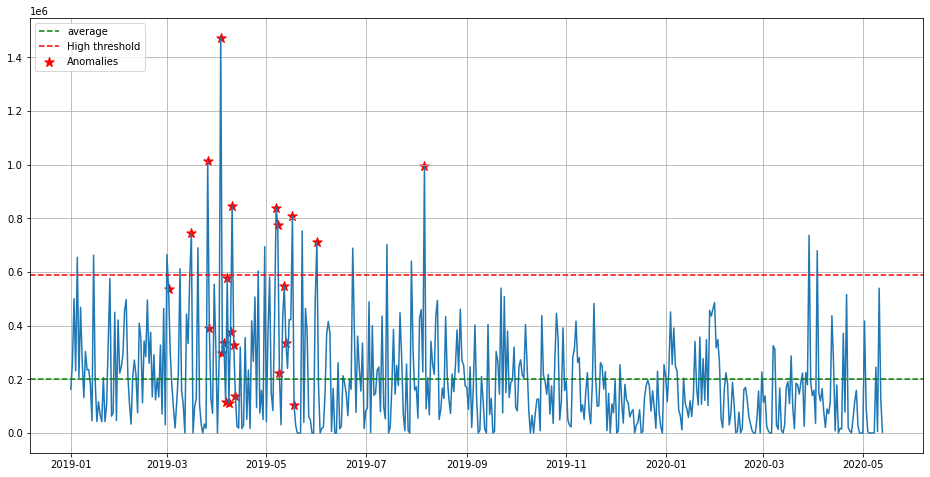

In [63]:
res = cusum_plot(data[data['id']==488].set_index('day')[['value']], 2)

In [11]:
temp = data[data['id']==488].copy().reset_index(drop=True)

In [14]:
temp['value_shift_1'] = temp['value'].shift(1)
temp['value_shift_-1'] = temp['value'].shift(0*-1)

In [15]:
temp

id        day   value  value_shift_1  value_shift_-1
0    488 2019-01-01  163357            NaN          163357
1    488 2019-01-02  258428       163357.0          258428
2    488 2019-01-03  501033       258428.0          501033
3    488 2019-01-04  231500       501033.0          231500
4    488 2019-01-05  654753       231500.0          654753
..   ...        ...     ...            ...             ...
494  488 2020-05-09  245696         1235.0          245696
495  488 2020-05-10    5831       245696.0            5831
496  488 2020-05-11  539743         5831.0          539743
497  488 2020-05-12  124618       539743.0          124618
498  488 2020-05-13    3049       124618.0            3049

[499 rows x 5 columns]